# Character-Level Tokenization and Embeddings

This notebook demonstrates character-level tokenization and embeddings using the Shakespeare dataset, following Andrej Karpathy's approach.

In [1]:
import torch
import numpy as np
from pathlib import Path

## Load and Inspect the Data

In [2]:
# Read the Shakespeare text
with open('../data/shakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print(f'Length of dataset in characters: {len(text)}')
print('\nFirst 1000 characters:\n')
print(text[:1000])

Length of dataset in characters: 1115394

First 1000 characters:

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods k

## Character-Level Tokenization

In character-level tokenization, each unique character in the text becomes a token. This is the simplest form of tokenization.

In [3]:
# Get all unique characters in the text
chars = sorted(list(set(text)))
vocab_size = len(chars)

print(f'Vocabulary size (unique characters): {vocab_size}')
print('\nAll characters:', ''.join(chars))

Vocabulary size (unique characters): 65

All characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [4]:
# Create mappings from characters to integers and back
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

# Example: encode and decode some text
example_text = "Hello, World!"
encoded = [char_to_idx[ch] for ch in example_text]
decoded = ''.join([idx_to_char[idx] for idx in encoded])

print(f'Original text: {example_text}')
print(f'Encoded: {encoded}')
print(f'Decoded: {decoded}')

Original text: Hello, World!
Encoded: [20, 43, 50, 50, 53, 6, 1, 35, 53, 56, 50, 42, 2]
Decoded: Hello, World!


## Character Embeddings

Now we'll create character embeddings. Each character will be represented by a vector in a higher-dimensional space.

In [5]:
# Parameters for embeddings
embedding_dim = 16  # Dimension of the embedding space

# Create a random embedding table
embeddings = torch.nn.Embedding(vocab_size, embedding_dim)

# Example: get embeddings for a sequence of characters
example_sequence = torch.tensor(encoded)  # Using the encoded text from above
embedded_sequence = embeddings(example_sequence)

print(f'Shape of embedded sequence: {embedded_sequence.shape}')
print('\nEmbedding for first character:')
print(embedded_sequence[0].detach().numpy())

Shape of embedded sequence: torch.Size([13, 16])

Embedding for first character:
[ 0.6884601   0.3109728  -0.5824377  -0.20082434 -0.2210619   0.64874357
 -1.0060755   0.69465595 -0.13522124  0.60802007 -0.19498079  0.5732174
 -1.7473048  -0.8110613  -1.3336892  -0.15343623]


## Creating Training Examples

Let's see how to create training examples for a language model. Each example will consist of a sequence of characters and the next character as the target.

In [6]:
# Convert entire text to indices
data = torch.tensor([char_to_idx[ch] for ch in text], dtype=torch.long)

# Create sequences of context_length characters
context_length = 8
x = torch.stack([data[i:i+context_length] for i in range(len(data)-context_length)])
y = data[context_length:]

print(f'Shape of input sequences: {x.shape}')
print(f'Shape of target values: {y.shape}')

# Show an example
idx = 0  # First sequence
context = ''.join([idx_to_char[int(i)] for i in x[idx]])
next_char = idx_to_char[int(y[idx])]
print(f'\nExample:')
print(f'Context: "{context}"')
print(f'Next character: "{next_char}"')

Shape of input sequences: torch.Size([1115386, 8])
Shape of target values: torch.Size([1115386])

Example:
Context: "First Ci"
Next character: "t"


## Visualizing Embeddings

We can visualize the learned embeddings by projecting them to 2D using PCA.

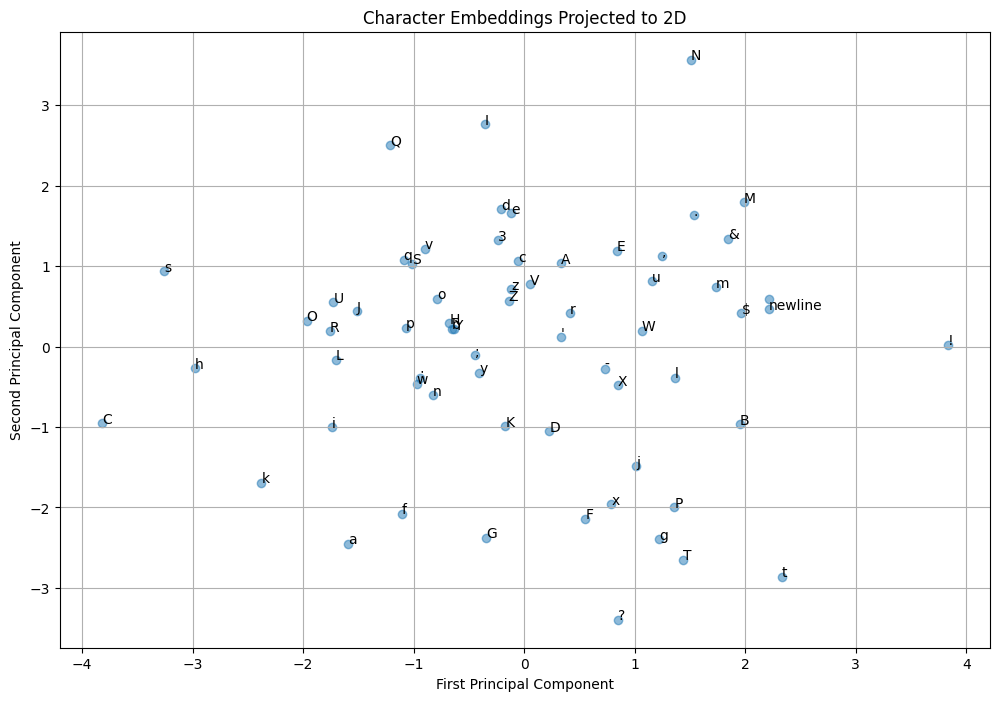

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Get the embedding weights
weights = embeddings.weight.detach().numpy()

# Project to 2D using PCA
pca = PCA(n_components=2)
projected = pca.fit_transform(weights)

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(projected[:, 0], projected[:, 1], alpha=0.5)

# Add character labels
for i, char in enumerate(chars):
    if char == '\n': char = 'newline'  # Make newline visible
    plt.annotate(char, (projected[i, 0], projected[i, 1]))

plt.title('Character Embeddings Projected to 2D')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.grid(True)
plt.show()